# Introduction

In this project, I analyze a simulated cohort generated from a coalescent-based genetic model. Each row corresponds to one individual and includes both demographic covariates and genotype-derived predictors suitable for statistical learning.

The dataset used in this project was generated using a population-genetic simulation pipeline built with msprime, a coalescent simulator designed for scalable and biologically realistic genomic data. Instead of relying on a pre-existing real-world dataset, this approach creates a fully synthetic cohort in which the true effect sizes, covariates, and sources of noise are known. This allows direct evaluation of how well different statistical learning methods recover the underlying structure of the data.

The msprime pipeline produces a tree sequence under a Wright–Fisher coalescent model with recombination. From this tree sequence, a diploid genotype matrix is extracted and filtered by minor allele frequency. A subset of variants is designated as causal, each assigned an effect size drawn from a specified distribution. These effect sizes are used to construct a standardized polygenic score for each simulated individual. In addition to genetic predictors, msprime generates demographic and environmental covariates—sex, age, and an environmental index—to mimic realistic non-genetic influences on phenotype.

A continuous quantitative trait (quant_trait) is then created from a linear model combining the polygenic score, covariates, and Gaussian noise. This produces a dataset with controlled polygenic signal, demographic structure, and stochastic variation. Optional principal components (PC1, PC2, …) derived from genotype PCA provide population-structure covariates when needed.

Overall, each row of the dataset includes:
- Demographic covariates: sex, age, env_index
- Genetic predictors: polygenic_score, optional PCA components
- Response variable: quant_trait

This design makes the dataset ideal for evaluating linear regression, subset selection, and shrinkage methods. Because the true generative parameters are known, the analysis can examine not only predictive performance (RMSE, R²) but also how closely the fitted models recover the true effect sizes used to generate the phenotype. A detailed description of the data-generation process is provided in the project’s msprime documentation.

The goals of this project are to use statistical learning methods to:
- quantify how much of the variation in the quantitative trait is explained by the polygenic score and covariates,
- evaluate whether controlling for population structure via principal components improves prediction,
- compare classical linear models, subset selection, and shrinkage methods, and
- assess how well the fitted models recover the true underlying effect sizes used during data generation.

# Imports and General Setup

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook")

In [13]:
cohort_path = "../data/3195663216_msprime_sim_cohort.csv"

cohort = pd.read_csv(cohort_path)

# EDA

## Cohort

In [14]:
cohort.head()

individual_id  sex   age  env_index  polygenic_score  quant_trait  \
0              0    0  63.0  -1.629140         0.760770    -0.318469   
1              1    1  67.0  -0.624573         0.519406     0.683869   
2              2    0  59.0  -0.243920         0.816273     1.795897   
3              3    0  41.0   0.771197        -0.721764    -0.526473   
4              4    0  33.0  -1.024086        -0.769897    -0.169940   

   disease_status  disease_prob       PC1        PC2  
0               1      0.387942  2.706997  10.632169  
1               1      0.583642  8.517080 -11.365962  
2               1      0.602745  2.731682  -4.373494  
3               0      0.402481 -2.823508  -3.385728  
4               0      0.177698  2.707803   2.536408

In [15]:
cohort.shape

(10000, 10)

In [16]:
cohort.dtypes

individual_id        int64
sex                  int64
age                float64
env_index          float64
polygenic_score    float64
quant_trait        float64
disease_status       int64
disease_prob       float64
PC1                float64
PC2                float64
dtype: object

In [17]:
cohort.isna().sum()

individual_id      0
sex                0
age                0
env_index          0
polygenic_score    0
quant_trait        0
disease_status     0
disease_prob       0
PC1                0
PC2                0
dtype: int64

In [18]:
cohort.isnull().sum()

individual_id      0
sex                0
age                0
env_index          0
polygenic_score    0
quant_trait        0
disease_status     0
disease_prob       0
PC1                0
PC2                0
dtype: int64

In [19]:
cohort.info()
cohort.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   individual_id    10000 non-null  int64  
 1   sex              10000 non-null  int64  
 2   age              10000 non-null  float64
 3   env_index        10000 non-null  float64
 4   polygenic_score  10000 non-null  float64
 5   quant_trait      10000 non-null  float64
 6   disease_status   10000 non-null  int64  
 7   disease_prob     10000 non-null  float64
 8   PC1              10000 non-null  float64
 9   PC2              10000 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 781.4 KB


individual_id           sex           age     env_index  \
count    10000.00000  10000.000000  10000.000000  10000.000000   
mean      4999.50000      0.494400     45.034500      0.003659   
std       2886.89568      0.499994     14.637101      1.002948   
min          0.00000      0.000000     20.000000     -3.486467   
25%       2499.75000      0.000000     32.000000     -0.665262   
50%       4999.50000      0.000000     45.000000      0.007784   
75%       7499.25000      1.000000     58.000000      0.671783   
max       9999.00000      1.000000     70.000000      4.048420   

       polygenic_score   quant_trait  disease_status  disease_prob  \
count     1.000000e+04  1.000000e+04    10000.000000  10000.000000   
mean     -7.531753e-17 -1.989520e-17        0.495400      0.499984   
std       1.000000e+00  1.000000e+00        0.500004      0.224913   
min      -3.425425e+00 -3.674438e+00        0.000000      0.019687   
25%      -6.886466e-01 -6.673733e-01        0.000000      0.318043   
50%       1.069430e-04 -4.147091e-03        0.000000      0.500888   
75%       6.954927e-01  6.718384e-01        1.000000      0.679591   
max       3.433686e+00  3.676401e+00        1.000000      0.973832   

                PC1           PC2  
count  1.000000e+04  1.000000e+04  
mean  -3.797140e-15  5.741185e-16  
std    8.915065e+00  8.576561e+00  
min   -2.241905e+01 -1.935404e+01  
25%   -6.362309e+00 -5.800355e+00  
50%   -1.984870e-01 -1.473405e+00  
75%    6.361650e+00  3.811644e+00  
max    2.766844e+01  4.090636e+01

### Age

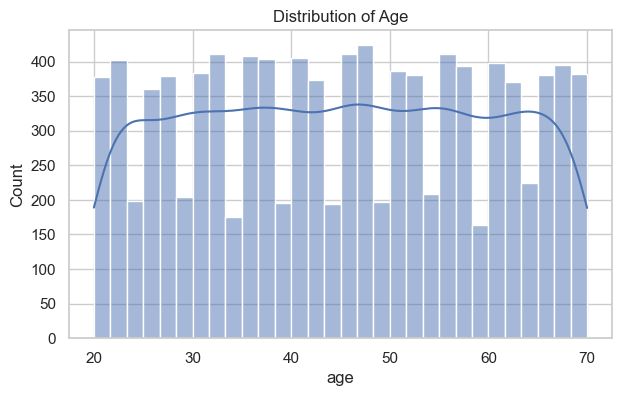

In [20]:
plt.figure(figsize=(7,4))
sns.histplot(cohort["age"], kde=True, bins=30)
plt.title("Distribution of Age")
plt.show()

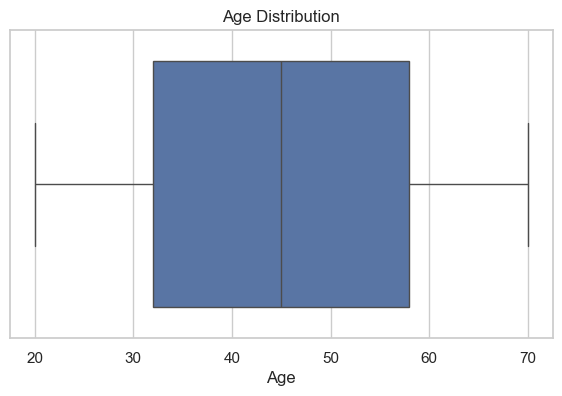

count    10000.000000
mean        45.034500
std         14.637101
min         20.000000
25%         32.000000
50%         45.000000
75%         58.000000
max         70.000000
Name: age, dtype: float64

In [21]:
plt.figure(figsize=(7,4))
sns.boxplot(x=cohort["age"])
plt.title("Age Distribution")
plt.xlabel("Age")
plt.show()

cohort["age"].describe()

### Env Index

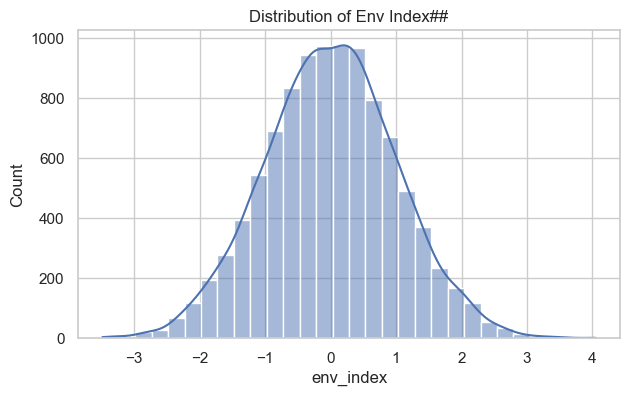

count    10000.000000
mean         0.003659
std          1.002948
min         -3.486467
25%         -0.665262
50%          0.007784
75%          0.671783
max          4.048420
Name: env_index, dtype: float64

In [22]:
plt.figure(figsize=(7,4))
sns.histplot(cohort["env_index"], kde=True, bins=30)
plt.title("Distribution of Env Index##")
plt.show()

cohort["env_index"].describe()

### Polygenic Score

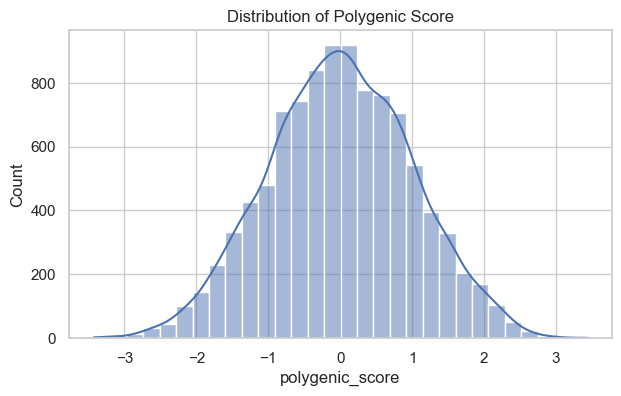

count    1.000000e+04
mean    -7.531753e-17
std      1.000000e+00
min     -3.425425e+00
25%     -6.886466e-01
50%      1.069430e-04
75%      6.954927e-01
max      3.433686e+00
Name: polygenic_score, dtype: float64

In [23]:
plt.figure(figsize=(7,4))
sns.histplot(cohort["polygenic_score"], kde=True, bins=30)
plt.title("Distribution of Polygenic Score")
plt.show()

cohort["polygenic_score"].describe()

### Quant Trait

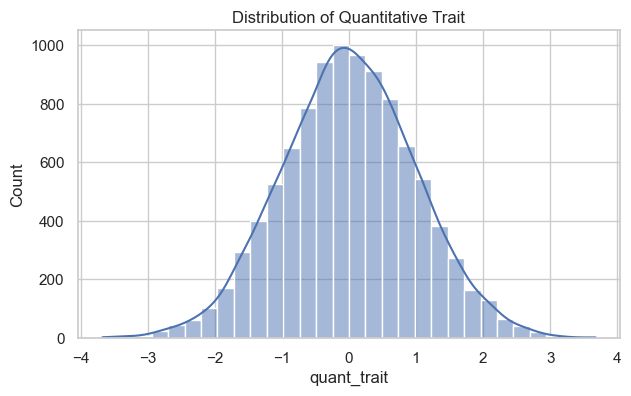

count    1.000000e+04
mean    -1.989520e-17
std      1.000000e+00
min     -3.674438e+00
25%     -6.673733e-01
50%     -4.147091e-03
75%      6.718384e-01
max      3.676401e+00
Name: quant_trait, dtype: float64

In [24]:
plt.figure(figsize=(7,4))
sns.histplot(cohort["quant_trait"], kde=True, bins=30)
plt.title("Distribution of Quantitative Trait")
plt.show()

cohort["quant_trait"].describe()

### Disease Prob

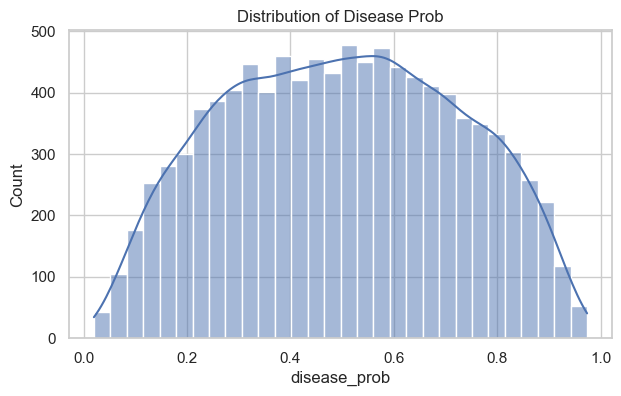

count    10000.000000
mean         0.499984
std          0.224913
min          0.019687
25%          0.318043
50%          0.500888
75%          0.679591
max          0.973832
Name: disease_prob, dtype: float64

In [25]:
plt.figure(figsize=(7,4))
sns.histplot(cohort["disease_prob"], kde=True, bins=30)
plt.title("Distribution of Disease Prob")
plt.show()

cohort["disease_prob"].describe()

### PC1

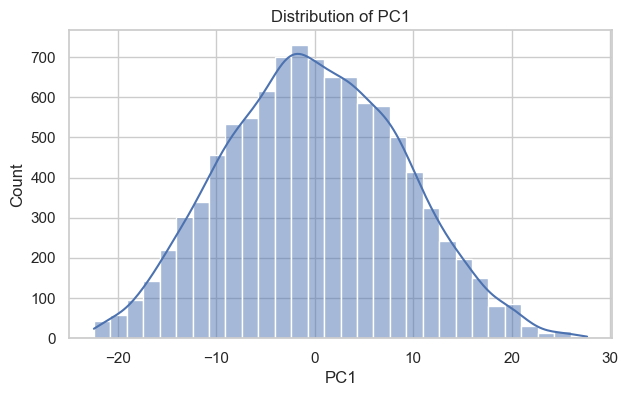

count    1.000000e+04
mean    -3.797140e-15
std      8.915065e+00
min     -2.241905e+01
25%     -6.362309e+00
50%     -1.984870e-01
75%      6.361650e+00
max      2.766844e+01
Name: PC1, dtype: float64

In [26]:
plt.figure(figsize=(7,4))
sns.histplot(cohort["PC1"], kde=True, bins=30)
plt.title("Distribution of PC1")
plt.show()

cohort["PC1"].describe()

### PC2

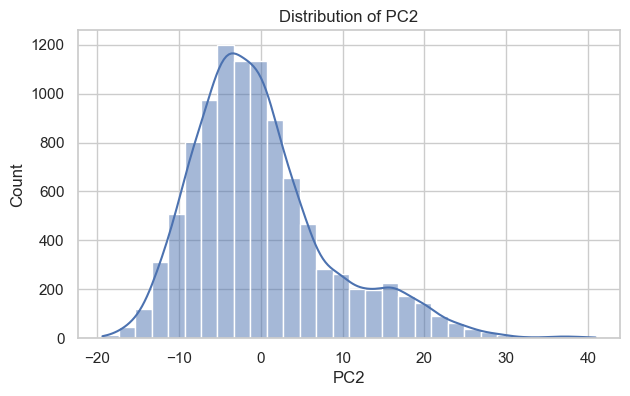

count    1.000000e+04
mean     5.741185e-16
std      8.576561e+00
min     -1.935404e+01
25%     -5.800355e+00
50%     -1.473405e+00
75%      3.811644e+00
max      4.090636e+01
Name: PC2, dtype: float64

In [27]:
plt.figure(figsize=(7,4))
sns.histplot(cohort["PC2"], kde=True, bins=30)
plt.title("Distribution of PC2")
plt.show()

cohort["PC2"].describe()

### Sex

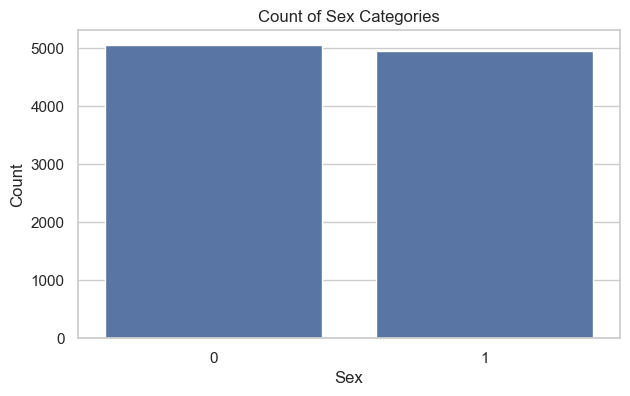

In [28]:
plt.figure(figsize=(7,4))
sns.countplot(x="sex", data=cohort)
plt.title("Count of Sex Categories")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

### Disease Status

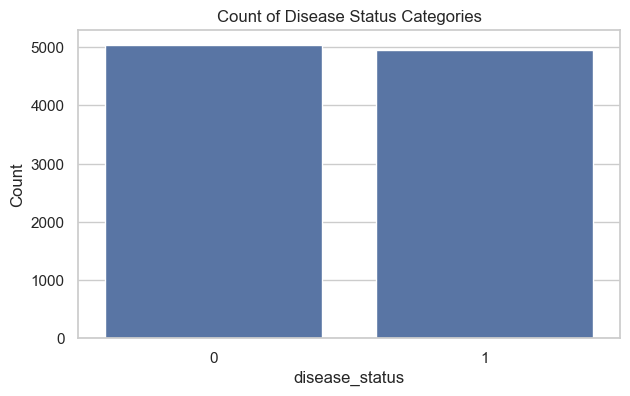

In [29]:
plt.figure(figsize=(7,4))
sns.countplot(x="disease_status", data=cohort)
plt.title("Count of Disease Status Categories")
plt.xlabel("disease_status")
plt.ylabel("Count")
plt.show()

### Correlations

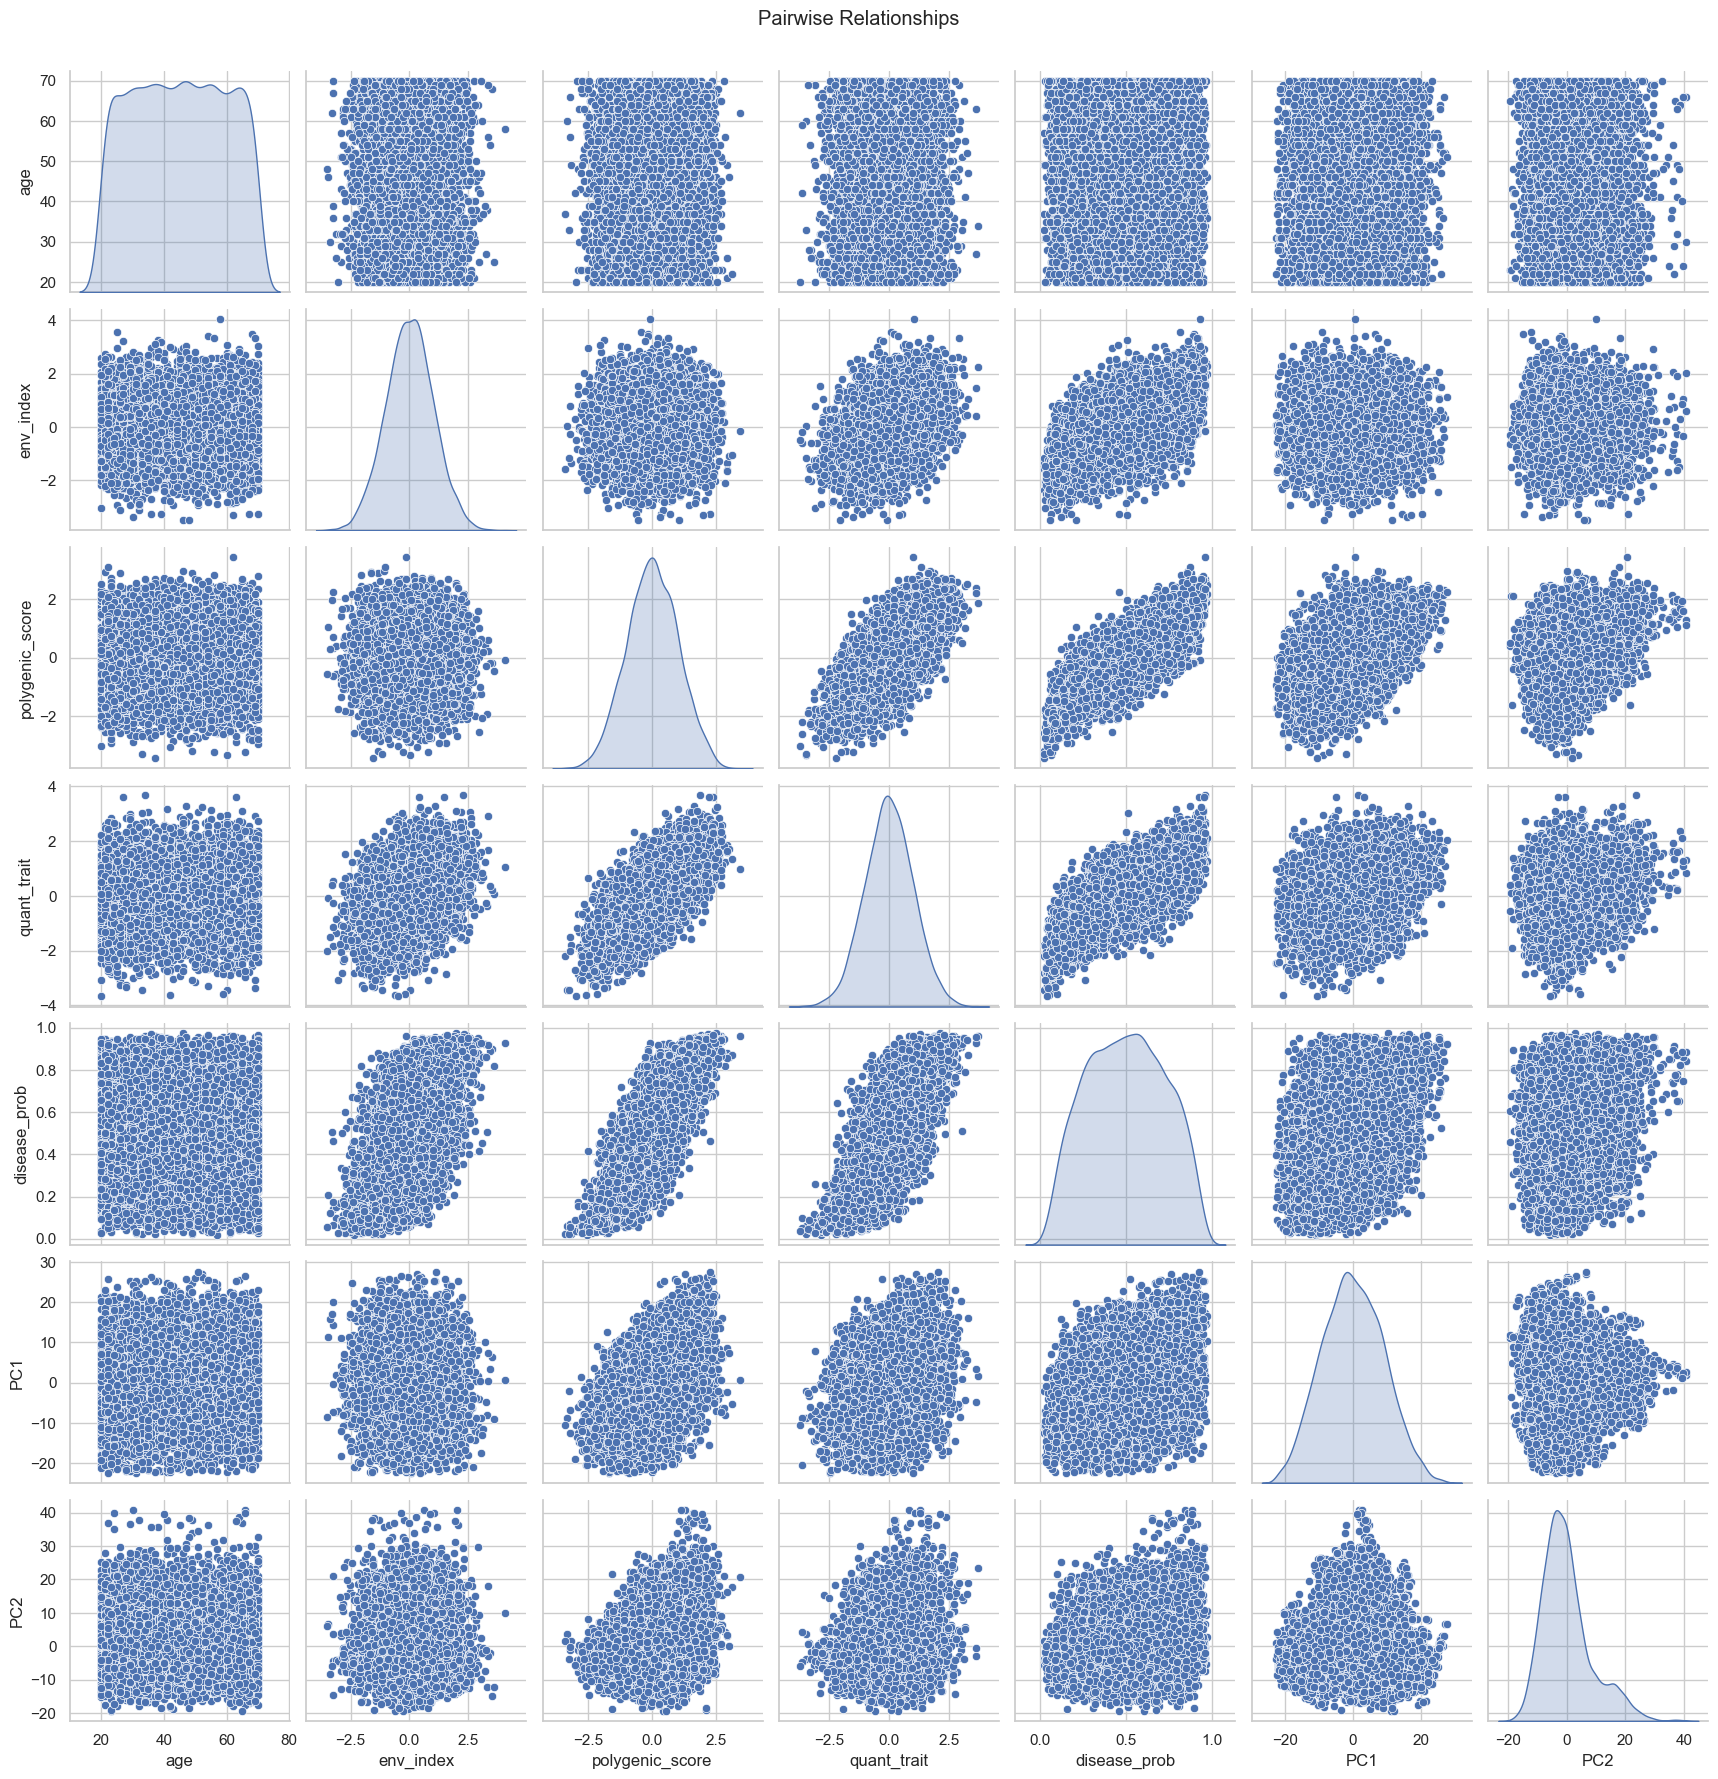

age  env_index  polygenic_score  quant_trait  \
age              1.000000  -0.000247         0.001887     0.014606   
env_index       -0.000247   1.000000         0.017408     0.353516   
polygenic_score  0.001887   0.017408         1.000000     0.663065   
quant_trait      0.014606   0.353516         0.663065     1.000000   
disease_prob     0.031899   0.547487         0.815232     0.739369   
PC1              0.000097   0.018066         0.470501     0.313810   
PC2             -0.007202  -0.011823         0.295038     0.201048   

                 disease_prob           PC1           PC2  
age                  0.031899  9.694601e-05 -7.202352e-03  
env_index            0.547487  1.806581e-02 -1.182278e-02  
polygenic_score      0.815232  4.705014e-01  2.950384e-01  
quant_trait          0.739369  3.138100e-01  2.010478e-01  
disease_prob         1.000000  3.914610e-01  2.363886e-01  
PC1                  0.391461  1.000000e+00  5.784070e-16  
PC2                  0.236389  5.784070e-16  1.000000e+00

In [30]:
cohort_numerical_vars = ["age", "env_index", "polygenic_score", "quant_trait", "disease_prob", "PC1", "PC2"]
sns.pairplot(cohort[cohort_numerical_vars], diag_kind="kde")
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

cohort[cohort_numerical_vars].corr()

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = cohort[cohort_numerical_vars]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns
print(vif)

         VIF          Feature
0  10.339426              age
1   1.845477        env_index
2   3.696521  polygenic_score
3   2.256771      quant_trait
4  12.326898     disease_prob
5   1.320267              PC1
6   1.126795              PC2


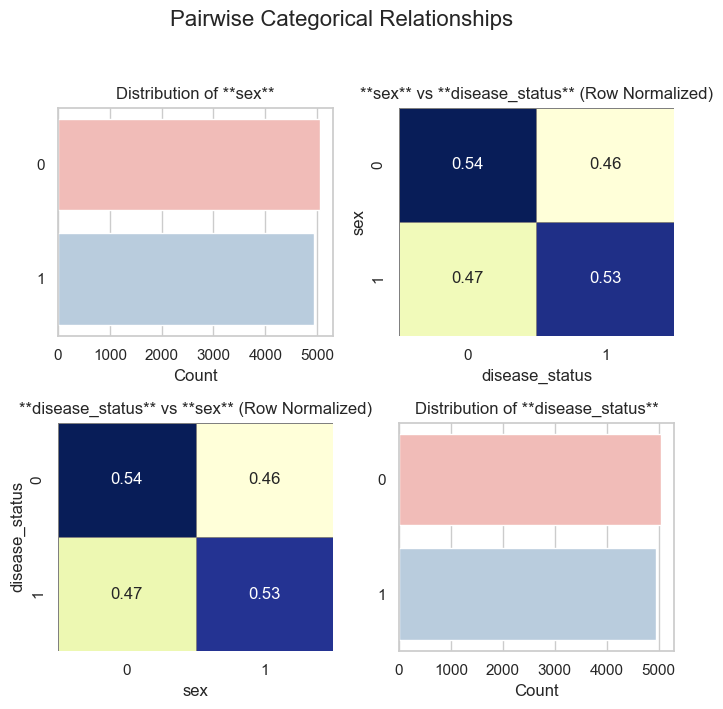

In [32]:
cohort_categorical_vars = ["sex", "disease_status"]
n_cohort_categorical_vars = len(cohort_categorical_vars)

fig, axes = plt.subplots(n_cohort_categorical_vars, n_cohort_categorical_vars, figsize=(n_cohort_categorical_vars * 3.5, n_cohort_categorical_vars * 3.5))
plt.suptitle("Pairwise Categorical Relationships", y=1.01, fontsize=16)

for i in range(n_cohort_categorical_vars):
    for j in range(n_cohort_categorical_vars):
        var1 = cohort_categorical_vars[i]
        var2 = cohort_categorical_vars[j]

        if i == j:
            sns.countplot(
                y=cohort[var1],
                ax=axes[i, j],
                hue=cohort[var1],
                palette="Pastel1",
                order=cohort[var1].value_counts().index,
                legend=False
            )
            axes[i, j].set_title(f"Distribution of **{var1}**", fontsize=12)
            axes[i, j].set_ylabel("")
            axes[i, j].set_xlabel("Count")

        else:
            contingency_table = pd.crosstab(cohort[var1], cohort[var2], normalize='index')
            sns.heatmap(
                contingency_table,
                annot=True,
                fmt=".2f",
                cmap="YlGnBu",
                cbar=False,
                ax=axes[i, j],
                linewidths=.5,
                linecolor='gray'
            )
            axes[i, j].set_title(f"**{var1}** vs **{var2}** (Row Normalized)", fontsize=12)
            axes[i, j].set_ylabel(var1)
            axes[i, j].set_xlabel(var2)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Variables vs Trait

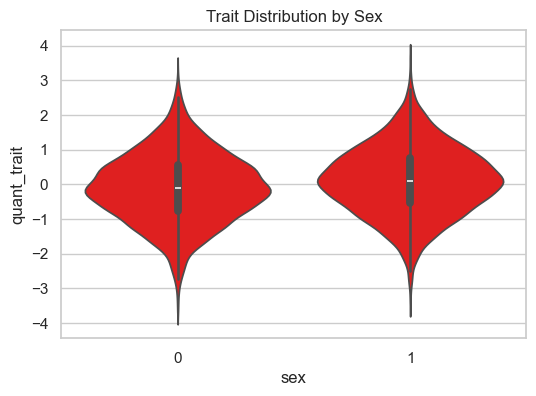

In [33]:
plt.figure(figsize=(6,4))
sns.violinplot(x=cohort["sex"], y=cohort["quant_trait"], color="red")
plt.title("Trait Distribution by Sex")
plt.show()

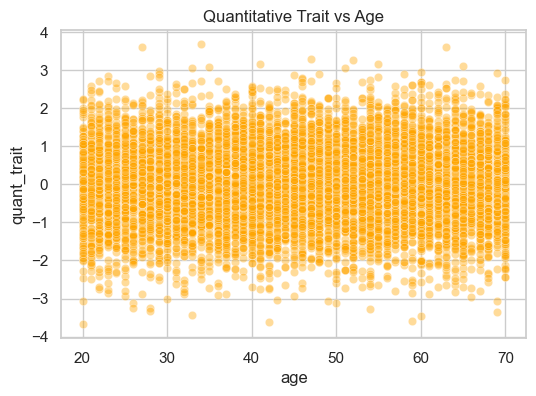

In [34]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=cohort["age"], y=cohort["quant_trait"], alpha=0.4, color="orange")
plt.title("Quantitative Trait vs Age")
plt.show()

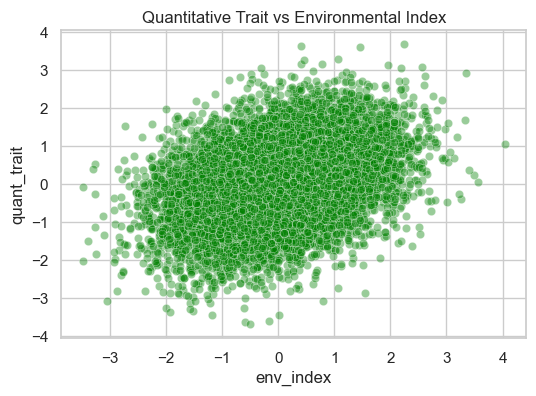

In [35]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=cohort["env_index"], y=cohort["quant_trait"], alpha=0.4, color="green")
plt.title("Quantitative Trait vs Environmental Index")
plt.show()

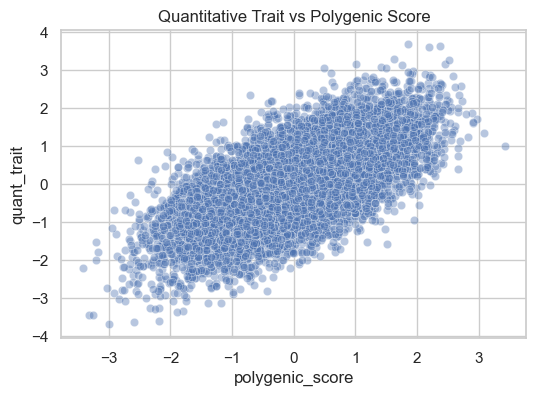

In [36]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=cohort["polygenic_score"], y=cohort["quant_trait"], alpha=0.4)
plt.title("Quantitative Trait vs Polygenic Score")
plt.show()

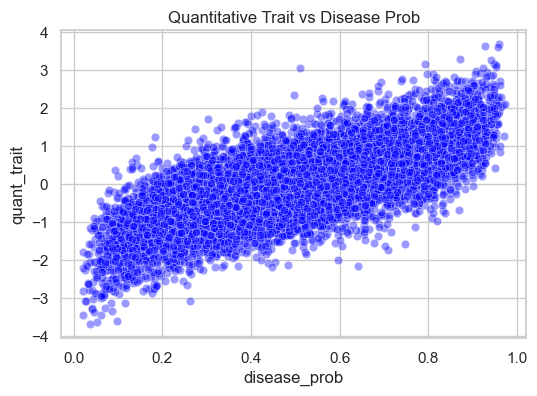

In [37]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=cohort["disease_prob"], y=cohort["quant_trait"], alpha=0.4, color="blue")
plt.title("Quantitative Trait vs Disease Prob")
plt.show()

### Correlation Matrix

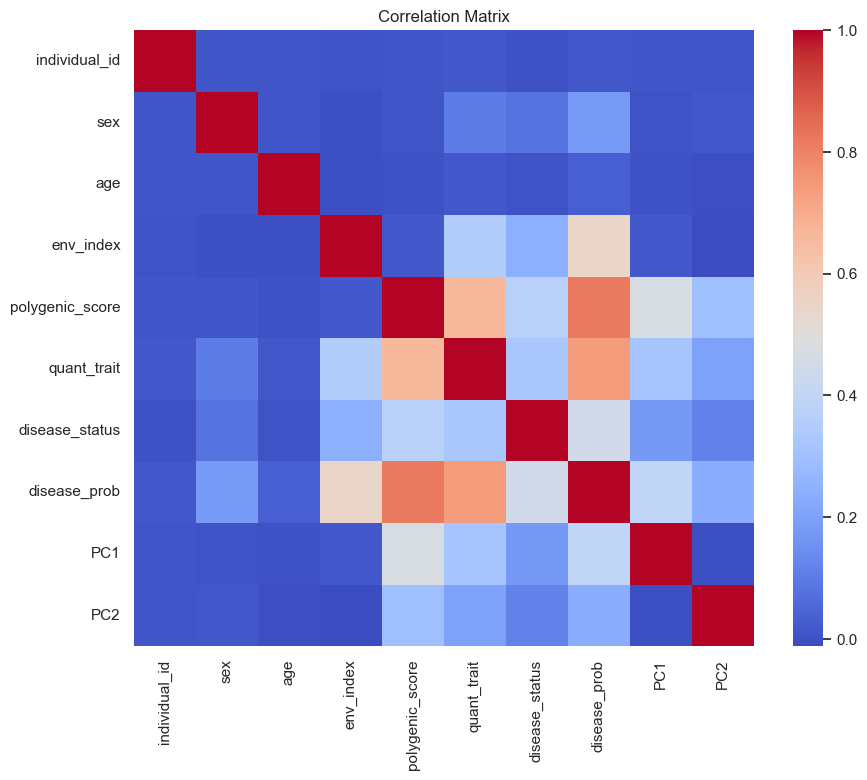

In [38]:
plt.figure(figsize=(10,8))
sns.heatmap(cohort.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### PCA Scatterplot

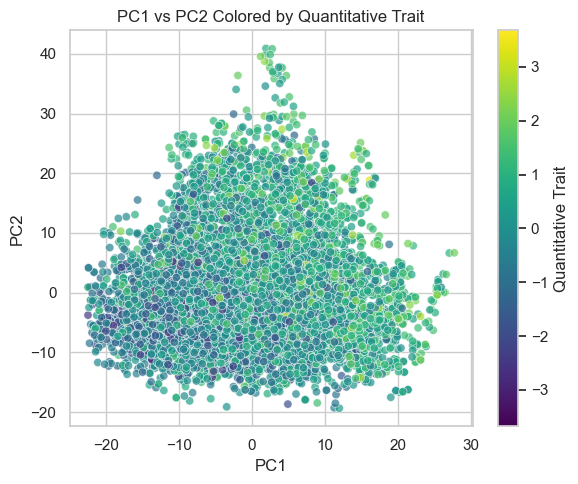

In [39]:
plt.figure(figsize=(6,5))

ax = plt.gca()

scatter = sns.scatterplot(
    x="PC1",
    y="PC2",
    data=cohort,
    hue="quant_trait",
    palette="viridis",
    alpha=0.7,
    legend=False,
    ax=ax
)

# Create normalization and ScalarMappable
norm = plt.Normalize(cohort["quant_trait"].min(), cohort["quant_trait"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Add colorbar **and tell it to use this Axes**
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Quantitative Trait")

# Labels and title
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PC1 vs PC2 Colored by Quantitative Trait")

plt.tight_layout()
plt.show()

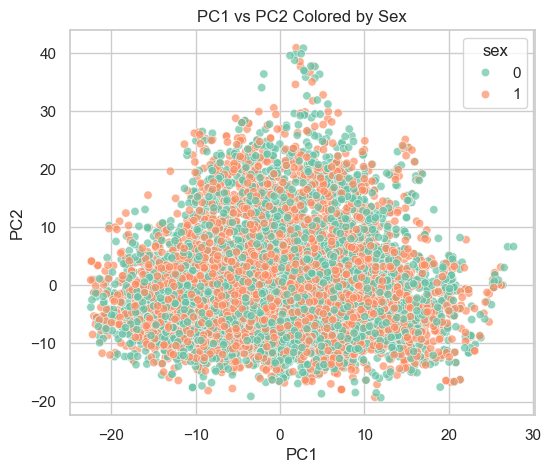

In [40]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=cohort,
    hue="sex",
    palette="Set2",
    alpha=0.7
)
plt.title("PC1 vs PC2 Colored by Sex")
plt.show()

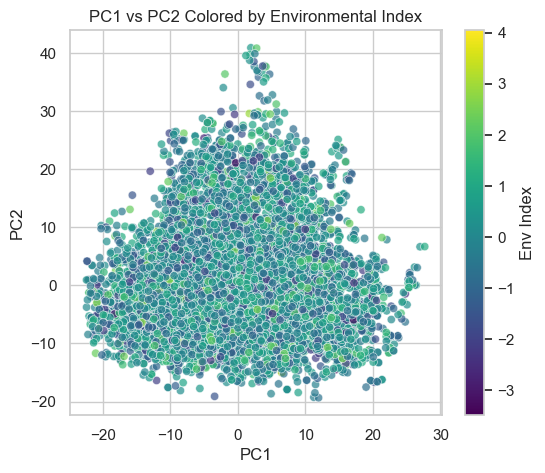

In [41]:
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    x="PC1",
    y="PC2",
    data=cohort,
    hue="env_index",
    palette="viridis",
    alpha=0.7,
    legend=False,
    ax=ax
)

# Add colorbar manually
norm = Normalize(cohort["env_index"].min(), cohort["env_index"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

fig.colorbar(sm, ax=ax, label="Env Index")

ax.set_title("PC1 vs PC2 Colored by Environmental Index")
plt.show()

### Outlier Detection

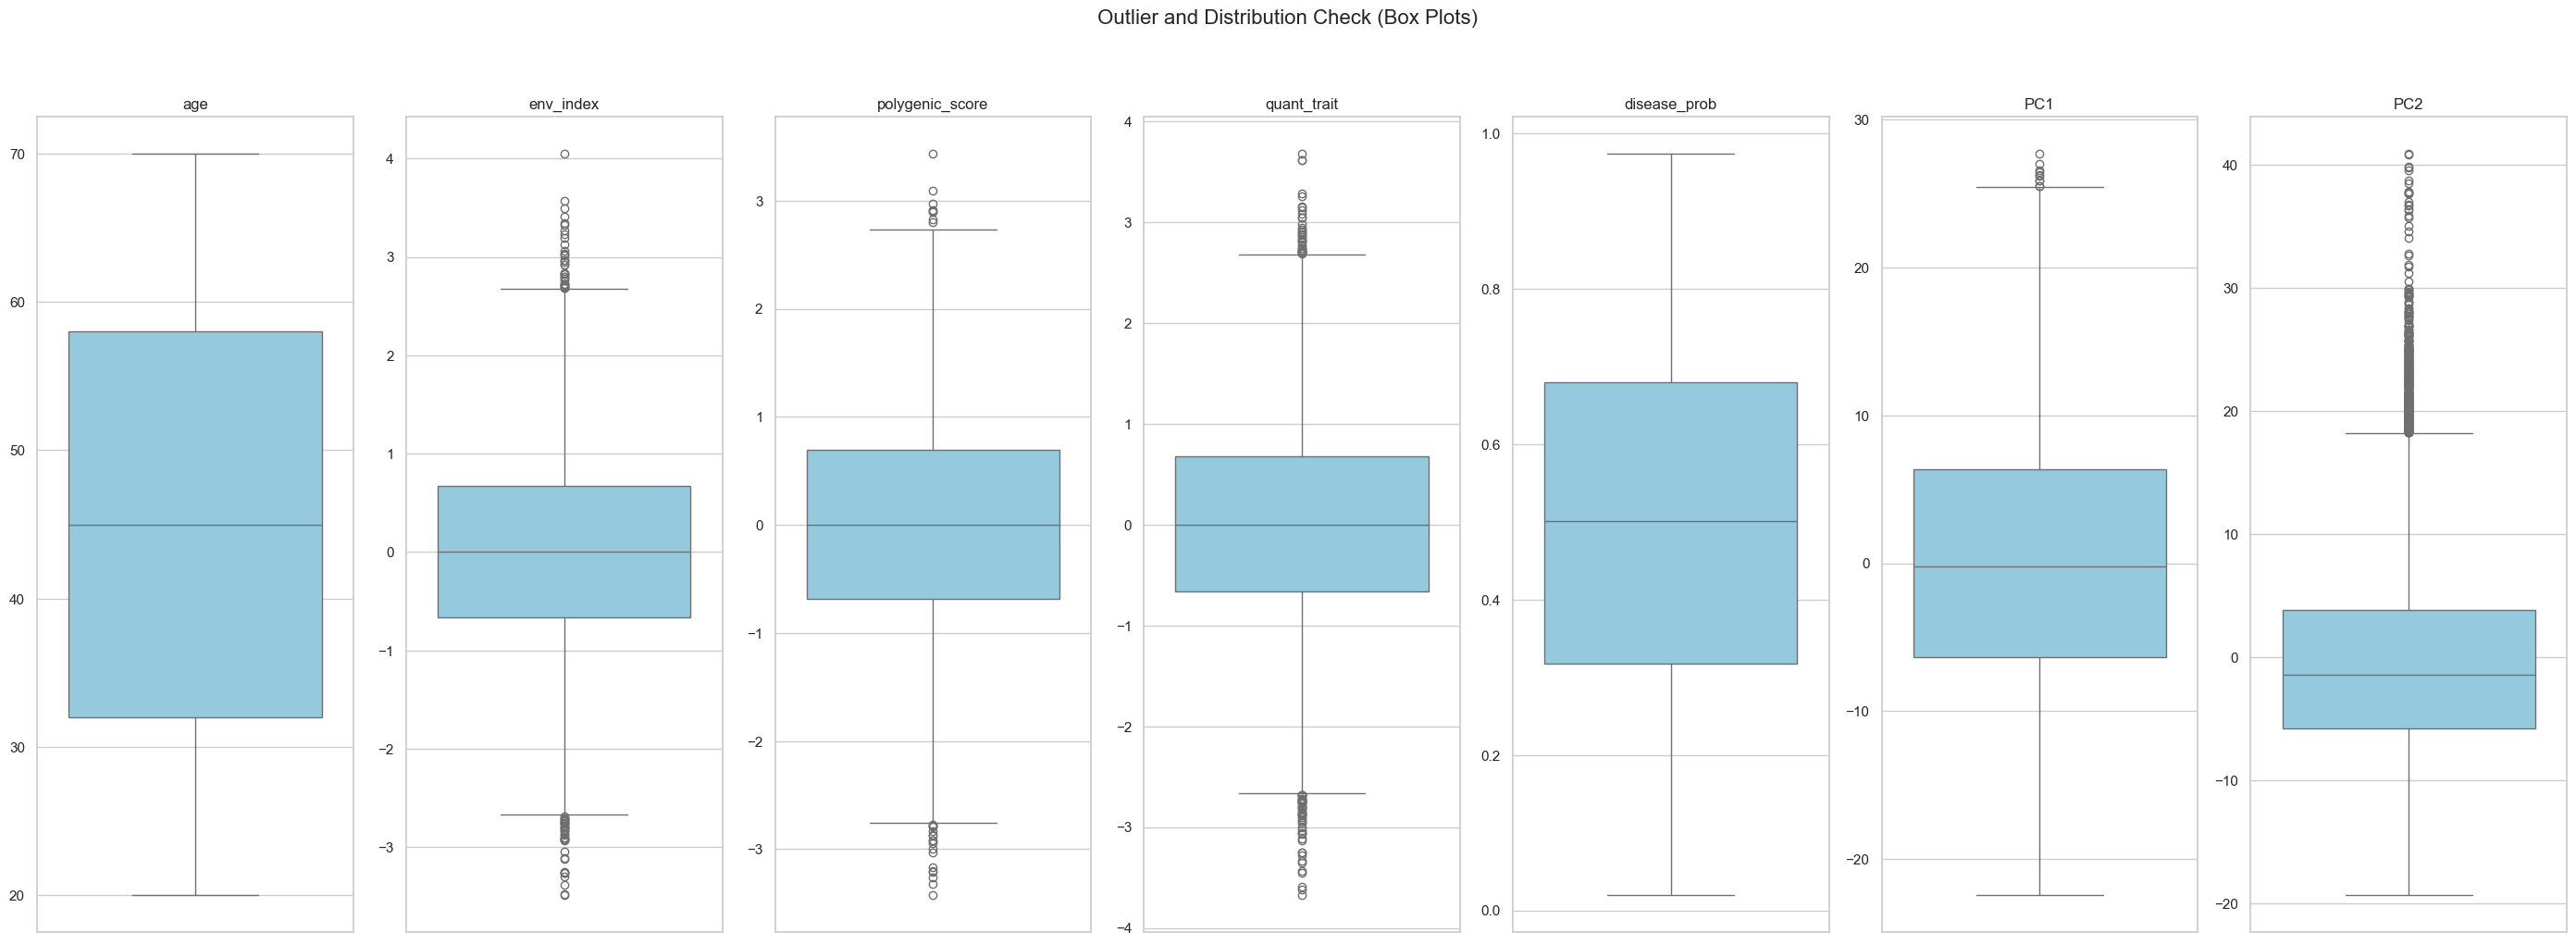

In [42]:
cohort_n_numerical_cols = len(cohort_numerical_vars)

fig, axes = plt.subplots(1, cohort_n_numerical_cols, figsize=(4 * cohort_n_numerical_cols, 10))
plt.suptitle("Outlier and Distribution Check (Box Plots)", fontsize=16, y=1.02)

for i, col in enumerate(cohort_numerical_vars):
    sns.boxplot(y=cohort[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_ylabel("")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Z-Scores

In [43]:
from scipy.stats import zscore

# Calculate z-scores
cohort["age_z"] = zscore(cohort["age"])
cohort["env_index_z"] = zscore(cohort["env_index"])
cohort["trait_z"] = zscore(cohort["quant_trait"])
cohort["pgs_z"] = zscore(cohort["polygenic_score"])
cohort["disease_prob_z"] = zscore(cohort["disease_prob"])
cohort["PC1_z"] = zscore(cohort["PC1"])
cohort["PC2_z"] = zscore(cohort["PC2"])

# Identify rows with extreme |z| > 3
age_outliers = cohort[cohort["age_z"].abs() > 3]
env_index_outliers = cohort[cohort["env_index_z"].abs() > 3]
trait_outliers = cohort[cohort["trait_z"].abs() > 3]
pgs_outliers = cohort[cohort["pgs_z"].abs() > 3]
disease_prob_outliers = cohort[cohort["disease_prob_z"].abs() > 3]
PC1_outliers = cohort[cohort["PC1_z"].abs() > 3]
PC2_outliers = cohort[cohort["PC2_z"].abs() > 3]

print("Age Outliers:")
display(age_outliers)

print("Env Index Outliers:")
display(env_index_outliers)

print("Trait Outliers:")
display(trait_outliers)

print("Polygenic Score Outliers:")
display(pgs_outliers)

print("Disease Prob Outliers:")
display(disease_prob_outliers)

print("PC1 Outliers:")
display(PC1_outliers)

print("PC2 Outliers:")
display(PC2_outliers)

Age Outliers:


Empty DataFrame
Columns: [individual_id, sex, age, env_index, polygenic_score, quant_trait, disease_status, disease_prob, PC1, PC2, age_z, env_index_z, trait_z, pgs_z, disease_prob_z, PC1_z, PC2_z]
Index: []

Env Index Outliers:


individual_id  sex   age  env_index  polygenic_score  quant_trait  \
341             341    0  38.0   3.268242        -1.909584    -0.388532   
807             807    0  39.0  -3.256558         2.233942     0.534361   
1425           1425    1  58.0   4.048420        -0.084291     1.059243   
1543           1543    0  70.0  -3.252614         0.336460    -1.835491   
2695           2695    0  25.0   3.567357        -0.448325     0.065579   
2952           2952    1  39.0   3.189585         0.422397     1.223410   
3047           3047    0  46.0  -3.474087         1.053978    -0.081547   
3132           3132    0  32.0  -3.116595         0.418144    -0.836613   
3557           3557    1  68.0   3.491974        -0.181512     0.228423   
3767           3767    1  54.0   3.408745        -0.190338     0.356762   
4298           4298    1  56.0   3.329388         0.221109     1.688806   
4960           4960    1  26.0  -3.108773        -0.562680    -1.341000   
4990           4990    0  30.0  -3.384238         0.302931    -1.488839   
5207           5207    0  69.0   3.342063         0.602977     2.922501   
5968           5968    1  47.0   3.031101         0.627754     1.600646   
6005           6005    1  70.0   3.026861        -1.239701     0.582563   
6644           6644    0  20.0  -3.045137        -1.750891    -3.060388   
7442           7442    0  37.0   3.126438         0.190937     0.679342   
7931           7931    0  67.0  -3.263119        -0.626276    -1.131370   
8279           8279    0  36.0  -3.259828         0.702996    -0.247488   
8328           8328    1  62.0  -3.294619         1.970823     0.404713   
8874           8874    0  60.0   3.063238        -2.048941     0.851893   
8959           8959    1  27.0   3.228016        -0.295966    -0.256893   
9137           9137    0  48.0  -3.486467        -0.556847    -2.022589   

      disease_status  disease_prob        PC1        PC2     age_z  \
341                0      0.506975  -8.009692 -12.066938 -0.480618   
807                1      0.461140  20.119693  -4.460362 -0.412295   
1425               1      0.929548   0.664120  10.048170  0.885841   
1543               1      0.142145  14.450845 -14.535762  1.705717   
2695               1      0.816956  -9.162362 -12.304398 -1.368816   
2952               1      0.922838  10.047782  -7.322282 -0.412295   
3047               0      0.208516  11.421396   6.798040  0.065966   
3132               0      0.151827  -7.309763  -4.747989 -0.890556   
3557               0      0.898338   6.495824 -15.007354  1.569071   
3767               1      0.890154   3.401532  -1.976413  0.612549   
4298               1      0.918273   0.376341  18.189550  0.749195   
4960               0      0.098795   1.878206  -4.238047 -1.300493   
4990               0      0.120392  15.922233  -8.403389 -1.027201   
5207               1      0.916601   7.342592  -2.803220  1.637394   
5968               1      0.930064 -17.570956   2.472944  0.134289   
6005               1      0.721428  -8.792966  -9.764399  1.705717   
6644               0      0.025229  -7.016000  -4.534812 -1.710431   
7442               0      0.861909 -11.632133  -0.645284 -0.548941   
7931               0      0.064374  -7.254872   3.703493  1.500748   
8279               1      0.176286  -0.335909  21.079570 -0.617264   
8328               1      0.507935  17.134273  -5.922309  1.159133   
8874               1      0.456254 -13.082843  -2.075437  1.022487   
8959               0      0.862175  -4.900511  -0.977054 -1.232170   
9137               0      0.058033  -8.556060   6.032512  0.202612   

      env_index_z   trait_z     pgs_z  disease_prob_z     PC1_z     PC2_z  
341      3.255152 -0.388552 -1.909680        0.031084 -0.898490 -1.407037  
807     -3.250797  0.534388  2.234054       -0.172716  2.256932 -0.520090  
1425     4.033075  1.059296 -0.084295        1.910003  0.074498  1.171644  
1543    -3.246864 -1.835583  0.336477       -1.591086  1.621028 -1.694909  

Trait Outliers:


individual_id  sex   age  env_index  polygenic_score  quant_trait  \
55               55    1  60.0   0.024134        -3.324746    -3.450029   
470             470    0  50.0  -1.570788        -1.395373    -3.129654   
538             538    0  30.0  -0.584755        -2.392583    -3.000630   
687             687    1  34.0   2.252178         1.853300     3.676401   
872             872    0  26.0  -1.222146        -1.175189    -3.109781   
1392           1392    0  47.0   1.064637         1.629027     3.287086   
1488           1488    0  26.0  -0.606161        -2.187053    -3.253065   
1630           1630    1  27.0   0.409911         2.372480     3.613300   
1764           1764    1  35.0   2.562380         1.411363     3.078510   
2142           2142    1  55.0   0.785097         2.460787     3.145882   
2760           2760    0  33.0  -1.175947        -3.263626    -3.433505   
2790           2790    0  59.0  -0.170791        -2.181061    -3.592296   
3224           3224    0  42.0  -0.593953        -2.589772    -3.620006   
3678           3678    1  69.0   0.792149        -1.958577    -3.062990   
4083           4083    0  20.0  -0.498510        -2.995812    -3.674438   
4371           4371    1  43.0  -1.245491        -2.830203    -3.028976   
4955           4955    1  28.0  -2.007439        -2.338433    -3.252634   
5257           5257    1  63.0   1.464862         2.193893     3.611756   
5530           5530    1  28.0  -1.515822        -1.788004    -3.335705   
5885           5885    0  33.0  -0.301659         0.494051     3.043239   
6279           6279    0  51.0   2.196375         1.504060     3.046456   
6644           6644    0  20.0  -3.045137        -1.750891    -3.060388   
7254           7254    0  54.0  -1.570459        -2.256907    -3.279698   
8075           8075    1  41.0   0.398916         1.004256     3.154279   
8689           8689    0  69.0  -1.931346        -1.898042    -3.350747   
8988           8988    1  65.0   1.961047         1.754560     3.115567   
9075           9075    1  52.0   0.462235         2.523959     3.255747   
9138           9138    0  49.0  -1.475149        -2.738472    -3.069301   

      disease_status  disease_prob        PC1        PC2     age_z  \
55                 0      0.060250  -8.848718   3.785936  1.022487   
470                0      0.084082  -1.501423  -6.923775  0.339258   
538                0      0.060940 -12.719575  -3.616202 -1.027201   
687                1      0.960708   1.577190  23.562006 -0.753910   
872                0      0.116092 -14.572613  -5.655727 -1.300493   
1392               1      0.870899  16.096333  18.832564  0.134289   
1488               0      0.071025 -12.021484  -1.849426 -1.300493   
1630               1      0.927184  -4.887179  -0.617219 -1.232170   
1764               1      0.951987   4.196454  13.832497 -0.685587   
2142               1      0.948152  -4.392800   5.697492  0.680872   
2760               1      0.020482  -1.964255  -3.684271 -0.822233   
2790               0      0.096494  -8.817396   4.358309  0.954164   
3224               0      0.052481 -20.598518  -4.756614 -0.207326   
3678               0      0.261476   7.960459  -0.600078  1.637394   
4083               0      0.037448 -10.473149  -5.762883 -1.710431   
4371               0      0.043163 -14.251821  -3.904479 -0.139003   
4955               0      0.041330  -8.295451  -3.778989 -1.163847   
5257               1      0.956488   3.338827  -2.963127  1.227456   
5530               0      0.086779  -3.414456   0.922623 -1.163847   
5885               1      0.509745   0.901399   0.613707 -0.822233   
6279               0      0.922992   7.304034  14.812822  0.407581   
6644               0      0.025229  -7.016000  -4.534812 -1.710431   
7254               0      0.040890  -6.139091  -7.724062  0.612549   
8075               1      0.791652   7.205335   5.139968 -0.275649   
8689               0      0.046623  -2.528092   0.721359  1.637394   
8988      

Polygenic Score Outliers:


individual_id  sex   age  env_index  polygenic_score  quant_trait  \
55               55    1  60.0   0.024134        -3.324746    -3.450029   
714             714    0  49.0  -1.351365        -3.166779    -1.792224   
2152           2152    0  22.0  -1.036083         3.096465     1.341943   
2649           2649    1  37.0  -1.565009        -3.425425    -2.192448   
2760           2760    0  33.0  -1.175947        -3.263626    -3.433505   
5115           5115    0  56.0   0.779590        -3.206921    -1.509827   
7921           7921    1  66.0  -0.274318        -3.202653    -1.999363   
8664           8664    1  42.0   0.317784        -3.027625    -2.723814   
9927           9927    1  62.0  -0.155078         3.433686     0.998583   

      disease_status  disease_prob        PC1        PC2     age_z  \
55                 0      0.060250  -8.848718   3.785936  1.022487   
714                0      0.020779 -12.582909   1.703357  0.270935   
2152               1      0.871911  -5.247178  17.787510 -1.573785   
2649               0      0.021075 -10.456278   1.697875 -0.548941   
2760               1      0.020482  -1.964255  -3.684271 -0.822233   
5115               1      0.069396  -6.853445  -1.123391  0.749195   
7921               0      0.057108 -12.626844  -0.322908  1.432425   
8664               0      0.087831 -18.952168  -5.507904 -0.207326   
9927               1      0.962022   0.758688  20.656930  1.159133   

      env_index_z   trait_z     pgs_z  disease_prob_z     PC1_z     PC2_z  
55       0.020416 -3.450201 -3.324912       -1.955225 -0.992608  0.441450  
714     -1.351108 -1.792313 -3.166938       -2.130725 -1.411492  0.198616  
2152    -1.036738  1.342010  3.096620        1.653726 -0.588604  2.074071  
2649    -1.564136 -2.192557 -3.425597       -2.129409 -1.172936  0.197977  
2760    -1.176197 -3.433677 -3.263790       -2.132046 -0.220341 -0.429596  
5115     0.773689 -1.509903 -3.207082       -1.914556 -0.768787 -0.130990  
7921    -0.277174 -1.999463 -3.202813       -1.969194 -1.416420 -0.037652  
8664     0.313218 -2.723950 -3.027777       -1.832588 -2.125965 -0.642236  
9927    -0.158278  0.998633  3.433858        2.054398  0.085106  2.408653

Disease Prob Outliers:


Empty DataFrame
Columns: [individual_id, sex, age, env_index, polygenic_score, quant_trait, disease_status, disease_prob, PC1, PC2, age_z, env_index_z, trait_z, pgs_z, disease_prob_z, PC1_z, PC2_z]
Index: []

PC1 Outliers:


individual_id  sex   age  env_index  polygenic_score  quant_trait  \
3573           3573    0  52.0   0.339104         1.285643     1.101838   
9277           9277    0  51.0   1.115918         2.239068     2.034296   

      disease_status  disease_prob        PC1       PC2     age_z  \
3573               1      0.764015  26.975441  6.641162  0.475904   
9277               0      0.923927  27.668438  6.673403  0.407581   

      env_index_z   trait_z     pgs_z  disease_prob_z     PC1_z     PC2_z  
3573     0.334476  1.101893  1.285707        1.173980  3.025978  0.774377  
9277     1.109046  2.034398  2.239180        1.885011  3.103715  0.778137

PC2 Outliers:


individual_id  sex   age  env_index  polygenic_score  quant_trait  \
202             202    0  70.0  -0.424810         0.510919    -1.286438   
242             242    0  57.0   1.305269         0.752604     1.377822   
257             257    0  64.0   2.923643         1.591498     2.207631   
282             282    0  49.0   0.211972         0.946518     0.332731   
364             364    1  43.0  -1.228626         0.893390     0.021822   
...             ...  ...   ...        ...              ...          ...   
9735           9735    0  29.0   1.328587         0.893390     1.172204   
9874           9874    0  66.0  -0.345604         1.609344     1.282368   
9883           9883    0  40.0   0.852659         1.933842     2.125335   
9902           9902    0  54.0  -1.807525         0.907879     0.530213   
9991           9991    1  34.0   1.557992         0.321546     1.127412   

      disease_status  disease_prob       PC1        PC2     age_z  \
202                0      0.514024  5.792330  26.345638  1.705717   
242                1      0.783305 -4.855154  26.849537  0.817518   
257                0      0.953709  1.694784  29.591804  1.295779   
282                1      0.687225 -2.164828  34.033211  0.270935   
364                1      0.565301 -4.511786  28.016510 -0.139003   
...              ...           ...       ...        ...       ...   
9735               1      0.797112 -4.511786  28.016510 -1.095524   
9874               1      0.747253  2.509537  39.881687  1.432425   
9883               1      0.885110  1.186007  39.561101 -0.343972   
9902               0      0.389587 -1.241341  27.748565  0.612549   
9991               0      0.802433  3.200424  26.589884 -0.753910   

      env_index_z   trait_z     pgs_z  disease_prob_z     PC1_z     PC2_z  
202     -0.427231 -1.286502  0.510945        0.062427  0.649756  3.071972  
242      1.297850  1.377891  0.752642        1.259751 -0.544628  3.130728  
257      2.911548  2.207742  1.591577        2.017432  0.190113  3.450484  
282      0.207712  0.332747  0.946565        0.832544 -0.242840  3.968364  
364     -1.228724  0.021823  0.893435        0.290425 -0.506111  3.266800  
...           ...       ...       ...             ...       ...       ...  
9735     1.321101  1.172262  0.893435        1.321142 -0.506111  3.266800  
9874    -0.348254  1.282433  1.609424        1.099454  0.281508  4.650312  
9883     0.846548  2.125441  1.933939        1.712415  0.133041  4.612930  
9902    -1.805951  0.530240  0.907925       -0.490866 -0.139248  3.235557  
9991     1.549843  1.127468  0.321562        1.344803  0.359008  3.100452  

[79 rows x 17 columns]